# Analyzing Sentiment in Amazon Product Reviews

In [2]:
import os
import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [1]:
def append_df_to_JSON(file, df):
    json_df = df.to_json(
        # path_or_buf=file_path,
        orient='records',
        lines=True
    )
    with open(file, 'a', encoding='utf8') as f:
        f.write(json_df)
        f.write("\n")
        
def gzip_file(load_path, save_path):
    import gzip
    import shutil
    with open(load_path, 'rb') as f_in:
        with gzip.open(save_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

### Stata File as DataFrame

In [3]:
data_path = "data/amazon/amazon_rating_review_final.dta"

In [10]:
column_order =[
    'gvkey',
    'year',
    'month',
    'asin',
    'category_id', 
    'brand', 
    'summary',
    'stars',
    'text'
]
# df = pd.read_stata(data_path, columns=target_columns)
# data_loader = pd.read_stata(data_path, columns=target_columns, chunksize=int(12224024/4))
# data_loader = pd.read_stata(data_path, chunksize=int(12224024/4))
data_loader = pd.read_stata(data_path, chunksize=1000)

In [5]:
df = next(iter(data_loader))
df

,gvkey,datadate,fyearq,fqtr,cik,year,month,cw_id,serial_no,brand,overall,asin,reviewtext,summary,vote,rank,price,category_id
0,001004,2015-11-30,2015.0,2.0,1750,2015.0,10.0,2,74391164,skycase,1,B014W1QGFU,I tried to give it a 0. The graphics are cool ...,The graphics are cool but the case is crap,0,NaN,NaN,All_Beauty
1,001004,2016-11-30,2016.0,2.0,1750,2016.0,11.0,2,74391164,skycase,1,B015ST1QW8,Phone case broke after a week of use! Contacte...,Unhappy,0,NaN,NaN,All_Beauty
2,001078,2003-03-31,2003.0,1.0,1800,2003.0,2.0,3,77614103,abbott,1,B00006RCLU,I would love to know what this dvd is about......,WHAT IS THIS?,0,503218.0,3.99,All_Beauty
3,001078,2003-06-30,2003.0,2.0,1800,2003.0,4.0,3,77614103,abbott,1,B00006RCLU,I assume this is at least 1 episode of their l...,I assume......,0,503218.0,3.99,All_Beauty
4,001078,2004-03-31,2004.0,1.0,1800,2004.0,1.0,3,77614103,abbott,1,B00006RCLU,My 1 star rating here is not related to Abbott...,Another Duplicate!,12,503218.0,3.99,All_Beauty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,001078,2018-03-31,2018.0,1.0,1800,2018.0,1.0,3,73294061,devine,3,B00TP0CVU8,Works well for keeping the fizz in but hard fo...,Seals well but tough to get on and off,0,NaN,7.95,All_Beauty
996,001078,2018-03-31,2018.0,1.0,1800,2018.0,2.0,3,73294061,devine,5,B00TP0CVU8,Gift and recipient liked it a lot.,Satisfied,0,NaN,7.95,All_Beauty
997,001078,2018-03-31,2018.0,1.0,1800,2018.0,2.0,3,73294061,devine,1,B00TP0CVU8,Junk. DOESN'T FIT.\n\nI couldn't get the whit...,JUNK. Doesn't fit in a champagne bottle.,0,NaN,7.95,All_Beauty
998,001078,2018-03-31,2018.0,1.0,1800,2018.0,2.0,3,73294061,devine,1,B00TP0CVU8,This does not work. Doesn't fit european sized...,Does not fit. Does not work.,0,NaN,7.95,All_Beauty


# Sentence Tokenization

In [2]:
import nltk
# nltk.download('punkt')
# nltk.download('words')

In [4]:
def tokenize_sentences(df, target_column, new_column=None, drop_target=False):
    if new_column is None:
        new_column = target_column
    start = time.time()
    df[new_column] = df[target_column].apply(nltk.tokenize.sent_tokenize)
    if drop_target:
        df.drop(columns=[target_column], inplace=True)
    df.replace("[]", "", inplace=True)

## Split Data by Sentence

In [ ]:
save_path = "data/amazon/amazon_stoken.json"

column_order =[
    'gvkey',
    'year',
    'month',
    'asin',
    'category_id', 
    'brand', 
    'summary',
    'stars',
    'text'
]

for df in tqdm(data_loader):
    
    # rename overall to stars for clarity
    df.rename(columns={'overall':'stars'}, inplace=True)
    
    # replace any newlines, tabs, returns with a blank space
    df.replace(r'\n|\t|\r', ' ', regex=True, inplace=True)
    
    # tokenize each review into sentences
    tokenize_sentences(df, "reviewtext", "text", drop_target=True)
    
    # split the reviews for a sentence on each row 
    # reindex to preserve review linkage
    df = df.explode('text')
    df['review_id'] = df.index
    
    # drop all rows that are nan
    df.dropna(axis=0, how='any', thresh=None, subset=['text'], inplace=True)
    
    # reorder for presentation value
    df = df[column_order]
    
    # save to JSON
    append_df_to_JSON(save_path, df)

# Save to JSON

In [11]:
save_path = "data/amazon/amazon_reviews2.json"

# column_order =[
#     'gvkey',
#     'year',
#     'month',
#     'asin',
#     'category_id', 
#     'brand', 
#     'summary',
#     'stars',
#     'text',
#     'num_words'
# ]

for df in tqdm(data_loader):
    
    # rename overall to stars for clarity
    df.rename(columns={'overall':'stars', 'reviewtext':'text'}, inplace=True)
    
    # replace any newlines, tabs, returns with a blank space
    df.replace(r'\n|\t|\r', ' ', regex=True, inplace=True)
    
    # drop all rows that are nan
    df.dropna(axis=0, how='any', thresh=None, subset=['text'], inplace=True)
    
    # add num_words for each review, possibly to filter later
    df['num_words'] = df['text'].apply(lambda x: len(x.split()))
    
    # add search hits
    df['neg_hits'] = df['text'].str.count(neg_regex, re.IGNORECASE) 
    df['pos_hits'] = df['text'].str.count(pos_regex, re.IGNORECASE)
    df['qua_hits'] = df['text'].str.count(qua_regex, re.IGNORECASE)
    
    # add an index column
    df['review_num'] = df.index
    
#     # reorder for presentation value
#     df = df[column_order]
    
    # save to JSON
    append_df_to_JSON(save_path, df)
    
load_path = "data/amazon/amazon_reviews2.json"
save_path = "data/amazon/amazon_reviews2.json.gz"
gzip_file(load_path, save_path)

# Topic Modeling
- https://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
- https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
- https://www.youtube.com/watch?v=3mHy4OSyRf0
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

In [3]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# import logging
# logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
# logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore

In [4]:
blacklist_words = [
    "excellent","good","great","like",
    "nice","better","pretty","decent",
    "bad","poor","don","stop",
    "really","lot","make","doing",
    "got", "ve", "use", "far", "ll",
    "went"
]

my_stopwords = STOPWORDS.union(blacklist_words)

english_words = set(nltk.corpus.words.words())

In [5]:
def tokenize(text):
    return [token for token in simple_preprocess(text) 
             if token in english_words 
            and token not in my_stopwords]

In [6]:
def iter_text(data_loader):
    for df in tqdm(data_loader):
        tokens = tokenize(str(df['text'].values))
        # tokens = tokenize(" ".join(str(df['text'].values)))
        yield tokens

In [7]:
# import gzip
# import shutil
# with open("data/amazon/amazon_stoken.json", 'rb') as f_in:
#     with gzip.open("data/amazon/amazon_stoken.json.gz", 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

In [31]:
load_path = "data/amazon/amazon_reviews.json"
chunksize = 1
data_loader = pd.read_json(load_path, lines=True, chunksize=chunksize)

In [32]:
doc_stream = (tokens for tokens in iter_text(data_loader))
id2word = gensim.corpora.Dictionary() # gensim.corpora.Dictionary(doc_stream) # gensim.corpora.Dictionary()

In [33]:
# id2word.save("data/amazon/id2word_amazon_1by1.gensim")
# id2word.save("data/amazon/id2word_amazon_reviews.gensim")

In [34]:
# 628,448 words
# id2word = id2word.load("data/amazon/id2word_amazon_1by1.gensim")

# 628,447 words
id2word = id2word.load("data/amazon/id2word_amazon_reviews.gensim")

In [36]:
# no_below=50  : 628,448 --> 45,600 
# no_below=100 : 628,448 --> 33,596
# no_below=150 : 628,448 --> 28,032
# no_below=250 : 628,448 --> 22,258
id2word.filter_extremes(no_below=50, no_above=0.90)

In [14]:
class ReviewCorpus(object):
    
    def __init__(self, load_path, dictionary, batch_size=1):
        
        self.load_path = load_path
        self.dictionary = dictionary
        self.batch_size = batch_size
        
        self.data_loader = pd.read_json(self.load_path, lines=True, chunksize=self.batch_size)
        
        self.count = 0
    
    def __iter__(self):
        
        for df in tqdm(self.data_loader):
            tokens = tokenize((str(df['text'].values)))
            self.count += self.batch_size
            yield self.dictionary.doc2bow(tokens)
    
    def __len__(self):
        return self.count

In [15]:
# review_corpus = ReviewCorpus(load_path, id2word)
# vector = next(iter(review_corpus))
# print(vector)

In [41]:
review_corpus = ReviewCorpus(load_path, id2word)
%time gensim.corpora.MmCorpus.serialize('data/amazon/amazon_reviews_english_bow.mm', review_corpus)
# Wall time: 2d 6h 24min 43s


Wall time: 15h 56min 29s


In [42]:
mm_corpus = gensim.corpora.MmCorpus('data/amazon/amazon_reviews_english_bow.mm')
print(mm_corpus)

MmCorpus(12223824 documents, 45587 features, 148216207 non-zero entries)


In [43]:
# clipped_corpus = gensim.utils.ClippedCorpus(mm_corpus, 1000000)  # use fewer documents during training, LDA is slow

In [44]:
# Set training parameters.
num_topics = 10
chunksize = 2000
iterations = 100
passes = 5
eval_every = None  # Don't evaluate model perplexity, takes too much time.

lda_model = gensim.models.LdaModel(
    corpus=mm_corpus,
    id2word=id2word,
    num_topics=num_topics,
    alpha='auto',
    eta='auto',
    chunksize=chunksize,
    iterations=iterations,
    passes=passes,
    eval_every=eval_every
)

In [45]:
lda_model.save('data/amazon/lda_model_reviews.gnsm')
# lda_model = gensim.models.LdaModel.load('data/amazon/lda_model.gnsm')

In [46]:
topics = lda_model.show_topics(10,15,formatted=False)

In [79]:
def df_topics(lda_model):
    topics = lda_model.show_topics(10,15,formatted=False)
    all_data = []
    for i in topics:
        words = []
        for j in i[1]:
            words.append(j[0])
        all_data.append([i[0], words])
    df = pd.DataFrame(all_data, columns=['topic', 'words'])
    df2 = pd.DataFrame(df["words"].to_list(), 
                   columns=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])
    return df2

In [80]:
df_topics(lda_model)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,works,easy,install,mount,simple,jeep,installation,bath,truck,floor,wife,protect,configure,security,stays
1,fit,love,perfect,little,right,perfectly,fine,look,looking,size,exactly,job,wish,color,cover
2,price,new,buy,camera,best,came,fast,happy,purchase,item,box,replacement,original,received,ordered
3,bought,case,small,way,thing,long,day,hard,bit,getting,car,sure,think,house,come
4,image,hot,air,baby,faster,warm,pump,taste,cold,cup,office,adapter,cat,write,cloud
5,product,time,work,working,money,support,service,took,tried,days,worth,times,month,said,return
6,video,data,hero,link,button,type,hand,class,normal,card,single,cut,hook,cap,mac
7,quality,phone,old,recommend,year,high,awesome,filter,backup,signal,replace,definitely,highly,amazing,fun
8,router,need,set,cable,light,battery,problem,want,unit,know,device,able,power,wireless,home
9,worked,water,clean,stick,remove,area,rental,glass,solution,shirt,rubber,stuck,bottle,heat,machine


In [122]:
df2

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,bought,new,got,far,working,months,years,ve,money,power,home,took,days,use,different
1,modem,comcast,set,software,box,mbps,arris,access,went,easily,ordered,loves,data,ubiquiti,range
2,router,worked,recommend,best,unit,issues,video,replacement,highly,house,getting,line,advertised,inside,connect
3,works,case,perfect,old,internet,fine,year,issue,expected,ll,running,hours,look,definitely,think
4,fit,light,small,size,little,version,big,devices,replace,plastic,bit,run,simple,new,bag
5,camera,problem,know,tried,installed,minutes,point,going,reviews,switch,job,color,mount,instructions,album
6,buy,need,battery,support,day,device,perfectly,needed,setup,fits,network,want,time,hard,update
7,product,easy,quality,price,install,service,amazon,backup,speed,drive,fast,purchase,item,acronis,high
8,time,phone,cable,wifi,use,came,problems,happy,long,looking,connection,signal,having,right,wanted
9,work,love,use,gopro,wireless,water,screen,filter,ac,hero,plus,clean,lens,number,port


In [53]:
df2.to_clipboard(excel=True)

# Coherence

In [51]:
from gensim.models import CoherenceModel

In [60]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=mm_corpus, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  -3.7603852979168537


In [72]:
def compute_coherence_values(model, id2word, corpus, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    model   : Gensim LDAModel
    id2word : Gensim dictionary
    corpus  : Gensim corpus
    limit   : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    # Set training parameters.
    num_topics = 10
    chunksize = 2000
    iterations = 100
    passes = 5
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(
            corpus=mm_corpus,
            id2word=id2word,
            num_topics=num_topics,
            alpha='auto',
            eta='auto',
            chunksize=chunksize,
            iterations=iterations,
            passes=passes,
            eval_every=eval_every
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=mm_corpus, dictionary=id2word, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [64]:
clipped_corpus = gensim.utils.ClippedCorpus(mm_corpus, 100000)  # use fewer documents during training, LDA is slow

In [73]:
model_list, coherence_values = compute_coherence_values(
    model = lda_model, 
    id2word = id2word, 
    corpus = clipped_corpus, 
    limit = 21, 
    start=5, 
    step=5
)

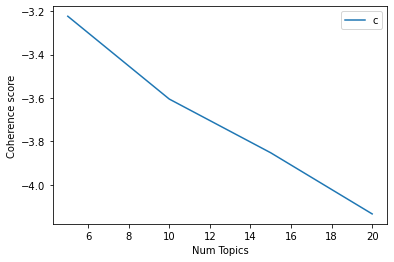

In [74]:
# Show graph
import matplotlib.pyplot as plt
limit=21
start=5 
step=5
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [81]:
df_topics(model_list[1])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,camera,video,speed,network,pro,picture,value,type,broke,class,upgrade,charger,reset,disk,mac
1,perfect,little,small,bit,size,big,wish,color,large,cute,smaller,space,useful,regular,cup
2,water,house,black,clean,inside,heavy,bath,cool,hot,outside,air,area,cap,fan,rental
3,time,bought,new,old,thing,right,year,long,came,hard,took,replacement,original,times,come
4,fit,case,phone,worked,perfectly,look,happy,purchase,looking,backup,easily,extra,feel,bag,cover
5,router,need,set,cable,battery,problem,unit,support,device,able,power,wireless,car,home,setup
6,work,light,working,job,fun,gift,thanks,bright,stuff,weight,dog,warranty,stopped,constantly,wonderful
7,way,sure,day,know,getting,service,want,going,think,box,different,tried,days,received,said
8,product,works,easy,love,quality,price,buy,recommend,install,best,fine,fast,awesome,filter,exactly
9,money,item,worth,pay,toy,album,thank,user,band,save,waste,rock,supposed,beautiful,complete


In [87]:
for i, num_topics in enumerate(range(start, limit, step)):
    save_path = 'data/amazon/lda_model_reviews_' + str(num_topics) + 'topics.gnsm'
    model_list[i].save(save_path)

# Keyword Lookups

In [6]:
from nltk.corpus import wordnet
import re

def all_synsets(word, pos=None):
    map = {
        'NOUN': wordnet.NOUN,
        'VERB': wordnet.VERB,
        'ADJ': wordnet.ADJ,
        'ADV': wordnet.ADV
    }
    if pos is None:
        pos_list = [wordnet.VERB, wordnet.ADJ, wordnet.NOUN, wordnet.ADV]
    else:
        pos_list = [map[pos]]
    ret = []
    for pos in pos_list:
        ret.extend(wordnet.synsets(word, pos=pos))
    return ret

def clean_senses(synsets):
    return [x for x in set(synsets) if '_' not in x]

def all_possible_synonyms(word, pos=None):
    ret = []
    for syn in all_synsets(word, pos=pos):
        ret.extend(syn.lemma_names())
    return clean_senses(ret)

def extend_w_synonyms(words, pos=None):
    synonyms = []
    for word in words:
        synonyms.extend(all_possible_synonyms(word, pos))
    return set(words).union(set(synonyms))

def recurse_synonyms(words, pos=None):
    num_words = len(words)
    while True:
        words = extend_w_synonyms(words, pos)
        if num_words == len(words):
            break
        num_words = len(words)
    return words

In [7]:
negative_words = 'data/amazon/negative_quality.txt'
positive_words = 'data/amazon/positive_quality.txt'
neg_words = set(pd.read_csv(negative_words).values.reshape(-1))
pos_words = set(pd.read_csv(positive_words).values.reshape(-1))

In [8]:
neg_words = extend_w_synonyms(neg_words, 'ADJ')
pos_words = extend_w_synonyms(pos_words, 'ADJ')
# neg_words = recurse_synonyms(neg_words, 'ADJ')
# pos_words = recurse_synonyms(pos_words, 'ADJ')
neg_words -= {'amazing','awesome','fair', 'firm', 'free', 'humble', 'light', 
              'loose', 'potent', 'strong', 'svelte', 'transparent', 'tremendous'}
pos_words -= {'awful', 'bad', 'bare', 'broken', 'frightful', 
              'stark', 'stiff', 'terrible', 'tough', 'tremendous'}

In [9]:
neg_regex = '(' + '|'.join(neg_words) +')'
pos_regex = '(' + '|'.join(pos_words) +')'
qua_regex = '(quality|quality is\s\w+|\w+\squality)'

In [117]:
load_path = "data/amazon/amazon_reviews.json"
data_loader = pd.read_json(load_path, lines=True, chunksize=1000)

In [118]:
# df['text'].str.findall(neg_regex, re.IGNORECASE) returns the strings that matched
# df['text'].str.count(neg_regex, re.IGNORECASE) returns the count of the above

In [119]:
save_path = "data/amazon/amazon_reviews_regexd.json"

In [120]:
for df in tqdm(data_loader):
    df['neg_hits'] = df['text'].str.count(neg_regex, re.IGNORECASE) 
    df['pos_hits'] = df['text'].str.count(pos_regex, re.IGNORECASE)
    df['qua_hits'] = df['text'].str.count(qua_regex, re.IGNORECASE)
    append_df_to_JSON(save_path, df)

In [116]:
# df2[['stars', 'text', 'neg_hits', 'pos_hits', 'qua_hits']]

In [121]:
df

,gvkey,year,month,asin,category_id,brand,summary,stars,text,num_words,neg_hits,pos_hits,qua_hits
12223000,164534,2015,8,B0067NW4NK,All_Beauty,zs,EXCEPTIONAL VALUE,5,Repeat order. Wife tested and approved. Great ...,12,0,1,1
12223001,164534,2015,10,B0067NW4NK,All_Beauty,zs,Hands Down!,5,I've got large hands. Some of the gloves have ...,20,1,0,0
12223002,164534,2016,7,B0067NW4NK,All_Beauty,zs,Didn't fit well,1,Did not fit even med hand size...only.very sma...,10,1,0,0
12223003,164534,2016,11,B0067NW4NK,All_Beauty,zs,Four Stars,4,The right size - well made,6,0,2,0
12223004,164534,2017,5,B0067NW4NK,All_Beauty,zs,Will buy more! Just what I needed!,5,Will buy more! Just what I needed!,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12223819,164534,2016,9,B019QH9DU0,All_Beauty,zs,Five Stars,5,Durable!,1,0,1,0
12223820,164534,2016,9,B019QH9DU0,All_Beauty,zs,Love it...small issue with volume being presse...,5,I love it...solid protection for my ipad pro.....,37,2,3,0
12223821,164534,2016,9,B019QH9DU0,All_Beauty,zs,Five Stars,5,Very good protective cover for my ipad at a re...,11,0,2,0
12223822,164534,2016,10,B019QH9DU0,All_Beauty,zs,Five Stars,5,Great case to toddler proof my device!,7,0,0,0


# Compress JSON

In [2]:
load_path = "data/amazon/amazon_reviews_regexd.json"
save_path = "data/amazon/amazon_reviews_regexd.json.gz"

In [124]:
import gzip
import shutil
with open(load_path, 'rb') as f_in:
    with gzip.open(save_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Save as Stata

In [2]:
load_path = "data/amazon/amazon_reviews2_regexd.json.gz"
save_path = "data/amazon/amazon_reviews2_regexd.dta"

In [3]:
%time df = pd.read_json(load_path, lines=True)

MemoryError: 

In [14]:
# df['asin'] = df['asin'].astype('str') 
# df['category_id'] = df['category_id'].astype('str') 
# df['brand'] = df['brand'].astype('str') 
# df['summary'] = df['summary'].astype('str') 
# df['text'] = df['text'].astype('str') 

In [4]:
column_order = ['review_num', 'gvkey', 'datadate', 'fyearq', 'fqtr', 'cik', 'year', 'month', 'cw_id',
       'serial_no', 'brand', 'stars', 'asin', 'text', 'summary', 'vote',
       'rank', 'price', 'category_id', 'num_words', 'neg_hits', 'pos_hits',
       'qua_hits']

df = df[column_order]

NameError: name 'df' is not defined

In [ ]:
%time df.to_stata(save_path, version=118)

# Compress Stata 

In [17]:
load_path = "data/amazon/amazon_reviews_regexd.dta"
save_path = "data/amazon/amazon_reviews_regexd.dta.gz"

In [18]:
gzip_file(load_path, save_path)

In [22]:
df

,gvkey,year,month,asin,category_id,brand,summary,stars,text,num_words,neg_hits,pos_hits,qua_hits
0,1078,2014,7,B00AAY3R3I,All_Beauty,abbott,"Nice, but could use a slight modification to d...",4,I ordered 3 of these and considering ordering ...,106,3,4,0
1,1078,2013,1,B00AAY3Z44,All_Beauty,abbott,Great set of dogs,5,I was very pleased and surprised at the overal...,53,0,7,1
2,1078,2013,4,B00AAY3Z44,All_Beauty,abbott,Great doorstop!,5,Whimsical Scottie dog heavy enough to hold the...,20,0,0,0
3,1078,2015,8,B00AAY3Z44,All_Beauty,abbott,Five Stars,5,Love my door stopper!! Heavy enough to retain...,13,0,0,0
4,1078,2018,2,B00AAY3Z44,All_Beauty,abbott,Nice and heavy,5,Brings a smile to people. Nice and heavy.,8,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12223819,164534,2016,9,B019QH9DU0,All_Beauty,zs,Five Stars,5,Durable!,1,0,1,0
12223820,164534,2016,9,B019QH9DU0,All_Beauty,zs,Love it...small issue with volume being presse...,5,I love it...solid protection for my ipad pro.....,37,2,3,0
12223821,164534,2016,9,B019QH9DU0,All_Beauty,zs,Five Stars,5,Very good protective cover for my ipad at a re...,11,0,2,0
12223822,164534,2016,10,B019QH9DU0,All_Beauty,zs,Five Stars,5,Great case to toddler proof my device!,7,0,0,0


In [19]:
load_path = "data/amazon/amazon_reviews2_regexd_0.dta"

In [20]:
data_loader = pd.read_stata(load_path, chunksize=1000)

In [21]:
first = True
for df in tqdm(data_loader):
    if first:
        df1 = df
        first = False

KeyboardInterrupt: 

In [15]:
df

,index,review_num,gvkey,datadate,fyearq,fqtr,cik,year,month,cw_id,...,text,summary,vote,rank,price,category_id,num_words,neg_hits,pos_hits,qua_hits
6112000,12224012,12224012,164534,1.522454e+12,2018,1,1794846,2018,3,1140089,...,I like them but they too small,One Star,0,NaN,35.99,All_Beauty,7,1,0,0
6112001,12224013,12224013,164534,1.467245e+12,2016,2,1794846,2016,5,1140089,...,Very cheap,Kids toy quality,0,NaN,NaN,All_Beauty,2,1,0,0
6112002,12224014,12224014,164534,1.514678e+12,2017,4,1794846,2017,10,1140089,...,Great product,Five Stars,0,NaN,NaN,All_Beauty,2,0,0,0
6112003,12224015,12224015,164534,1.459382e+12,2016,1,1794846,2016,3,1140089,...,Works good. My 2 year old throws her iPad and ...,Five Stars,0,NaN,13.99,All_Beauty,16,0,2,0
6112004,12224016,12224016,164534,1.467245e+12,2016,2,1794846,2016,5,1140089,...,fine but leaves teh glass xposed,fine but leaves teh glass,0,NaN,13.99,All_Beauty,6,0,1,0
6112005,12224017,12224017,164534,1.467245e+12,2016,2,1794846,2016,6,1140089,...,My 6 year old loves it and it apparently is ve...,Five Stars,0,NaN,13.99,All_Beauty,17,0,1,0
6112006,12224018,12224018,164534,1.475194e+12,2016,3,1794846,2016,8,1140089,...,"Great cover, I would of given it 5 stars but i...",Three Stars,0,NaN,13.99,All_Beauty,17,0,0,0
6112007,12224019,12224019,164534,1.475194e+12,2016,3,1794846,2016,9,1140089,...,Durable!,Five Stars,0,NaN,13.99,All_Beauty,1,0,1,0
6112008,12224020,12224020,164534,1.475194e+12,2016,3,1794846,2016,9,1140089,...,I love it...solid protection for my ipad pro.....,Love it...small issue with volume being presse...,0,NaN,13.99,All_Beauty,37,2,3,0
6112009,12224021,12224021,164534,1.475194e+12,2016,3,1794846,2016,9,1140089,...,Very good protective cover for my ipad at a re...,Five Stars,0,NaN,13.99,All_Beauty,11,0,2,0


In [10]:
df

,index,review_num,gvkey,datadate,fyearq,fqtr,cik,year,month,cw_id,...,text,summary,vote,rank,price,category_id,num_words,neg_hits,pos_hits,qua_hits
6112000,6112000,6112000,3026,1.443571e+12,2015,3,313927,2015,7,2442,...,Love the idea of this BUT the steel frame for ...,Disappointing Results,3,45218.0,25.49,All_Beauty,47,1,1,0
6112001,6112001,6112001,3026,1.443571e+12,2015,3,313927,2015,7,2442,...,Love these bowls! They arr perfect!,Five Stars,0,45218.0,25.49,All_Beauty,6,0,1,0
6112002,6112002,6112002,3026,1.443571e+12,2015,3,313927,2015,7,2442,...,My border collie gets this off of the cage in ...,not great,0,45218.0,25.49,All_Beauty,50,1,2,0
6112003,6112003,6112003,3026,1.443571e+12,2015,3,313927,2015,7,2442,...,My dog had her water bowl out of the holder an...,My dog had her water bowl out of the holder ...,0,45218.0,25.49,All_Beauty,60,2,2,0
6112004,6112004,6112004,3026,1.443571e+12,2015,3,313927,2015,7,2442,...,My dog kept knocking his food into his water d...,Plus it doesn't end up on the floor which is t...,0,45218.0,25.49,All_Beauty,58,1,5,0
6112005,6112005,6112005,3026,1.443571e+12,2015,3,313927,2015,7,2442,...,"Nice bowl, but the attachment design could be ...",Attachment needs improvement,0,45218.0,25.49,All_Beauty,18,0,2,0
6112006,6112006,6112006,3026,1.443571e+12,2015,3,313927,2015,7,2442,...,"Nothing wrong with the bowl itself, but the br...",but the bracket is crap. Plastic coating start...,0,45218.0,25.49,All_Beauty,37,2,0,0
6112007,6112007,6112007,3026,1.443571e+12,2015,3,313927,2015,7,2442,...,OK for small dogs but the larger ones knocked ...,Three Stars,0,45218.0,25.49,All_Beauty,16,1,2,0
6112008,6112008,6112008,3026,1.443571e+12,2015,3,313927,2015,7,2442,...,Our puppy broke the weld on they clamp in one day,Three Stars,0,45218.0,25.49,All_Beauty,11,0,1,0
6112009,6112009,6112009,3026,1.443571e+12,2015,3,313927,2015,7,2442,...,Perfect for shipping our dog to Hawaii,Perfect,0,45218.0,25.49,All_Beauty,7,0,1,0


In [17]:
load_path = "data/amazon/amazon_reviews2_regexd_1.dta"
save_path = "data/amazon/amazon_reviews2_regexd_1.dta.gz"
gzip_file(load_path, save_path)

In [3]:
load_path = "data/glassdoor/glassdoor_topics_v2.dta"
save_path = "data/glassdoor/glassdoor_topics_v2.dta.gz"
gzip_file(load_path, save_path)